In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

### **Data Exploration**

In [2]:
# Load the dataset
canada_usa_df = pd.read_csv('canada_usa.csv')
canada_usa_df.info()
canada_usa_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  209 non-null    float64
 1   latitude   209 non-null    float64
 2   country    209 non-null    object 
dtypes: float64(2), object(1)
memory usage: 5.0+ KB


,longitude,latitude,country
0,-130.0437,55.9773,USA
1,-134.4197,58.3019,USA
2,-123.0780,48.9854,USA
3,-122.7436,48.9881,USA
4,-122.2691,48.9951,USA


In [3]:
# Count the samples per class
canada_usa_df['country'].value_counts()

country
Canada    128
USA        81
Name: count, dtype: int64

In [4]:
# Encode the categorical columns into numerical columns
le = LabelEncoder()
canada_usa_df['country'] = le.fit_transform(canada_usa_df['country'])
canada_usa_df.head()

,longitude,latitude,country
0,-130.0437,55.9773,1
1,-134.4197,58.3019,1
2,-123.0780,48.9854,1
3,-122.7436,48.9881,1
4,-122.2691,48.9951,1


### **Model Training**

In [5]:
# Split the dataset into features and target variable
X = canada_usa_df.drop(columns='country')
y = canada_usa_df['country']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training: {X_train.shape[0]}')
print(f'Testing: {X_test.shape[0]}')

Training: 167
Testing: 42


In [6]:
# Train models with different max depth
shallow_model = DecisionTreeClassifier(max_depth=1, random_state=42)
shallow_model.fit(X_train, y_train)

normal_model = DecisionTreeClassifier(max_depth=8, random_state=42)
normal_model.fit(X_train, y_train)

deep_model = DecisionTreeClassifier(max_depth=15, random_state=42)
deep_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=42)

### **Model Evaluation**

In [7]:
shallow_score = shallow_model.score(X_test, y_test)
normal_score = normal_model.score(X_test, y_test)
deep_score = deep_model.score(X_test, y_test)

print(f'Shallow Model Accuracy: {shallow_score:.4f}')
print(f'Normal Model Accuracy: {normal_score:.4f}')
print(f'Deep Model Accuracy: {deep_score:.4f}')

Shallow Model Accuracy: 0.8571
Normal Model Accuracy: 0.7619
Deep Model Accuracy: 0.7381


In [8]:
# Perform cross-validation in each depth
depth_cv_results = []

# Train and evaluate models with different max depths
for max_depth in range(1, 16):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    cv_results = cross_validate(model, X, y, cv=5, return_train_score=True)
    model.fit(X_train, y_train)
    
    # Store the results
    depth_cv_results.append({
        'Depth': max_depth,
        'Training Score': cv_results['train_score'].mean(),
        'Validation Score': cv_results['test_score'].mean()
    })

results_df = pd.DataFrame(depth_cv_results)
results_df

,Depth,Training Score,Validation Score
0,1,0.828985,0.809292
1,2,0.831366,0.809292
2,3,0.880453,0.804530
3,4,0.900749,0.780720
4,5,0.919903,0.790244
5,6,0.931865,0.766318
6,7,0.948610,0.795122
7,8,0.959374,0.785598
8,9,0.976112,0.799884
9,10,0.983269,0.776074


In [9]:
# Calculate differences in validation scores and gaps
results_df['Validation Drop'] = results_df['Validation Score'].diff(-1).fillna(0)  # Drop to the next depth
results_df['Score Gap'] = abs(results_df['Training Score'] - results_df['Validation Score'])

# Define thresholds
validation_threshold = 0.01  # Allowable drop in validation score
gap_threshold = 0.05         # Maximum acceptable gap for a model

# Start with the model with the highest validation score
best_model_idx = results_df['Validation Score'].idxmax()
best_model = results_df.loc[best_model_idx]

# Check subsequent depths for adjustments
for idx in range(best_model_idx + 1, len(results_df)):
    if (
        results_df.loc[idx, 'Validation Score'] >= best_model['Validation Score'] - validation_threshold
        and results_df.loc[idx, 'Score Gap'] <= gap_threshold
    ):
        best_model = results_df.loc[idx]

print("Selected Best Model:")
print(best_model)

Selected Best Model:
Depth               2.000000
Training Score      0.831366
Validation Score    0.809292
Validation Drop     0.004762
Score Gap           0.022074
Name: 1, dtype: float64


### **Model Visualization**

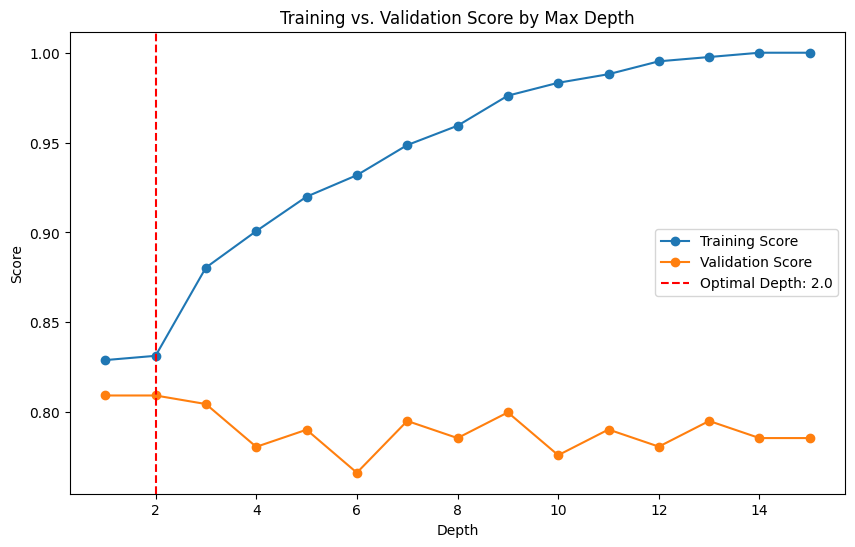

In [10]:
# Visualize the cross-validation scores and the optimal max depth
best_max_depth = best_model['Depth']

plt.figure(figsize=(10, 6))
plt.plot(results_df['Depth'], results_df['Training Score'], label='Training Score', marker='o')
plt.plot(results_df['Depth'], results_df['Validation Score'], label='Validation Score', marker='o')
plt.axvline(best_max_depth, color='red', linestyle='--', label=f'Optimal Depth: {best_max_depth}')
plt.title('Training vs. Validation Score by Max Depth')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.legend()
plt.show()

c:\Users\Jhondale\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Jhondale\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Jhondale\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Jhondale\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


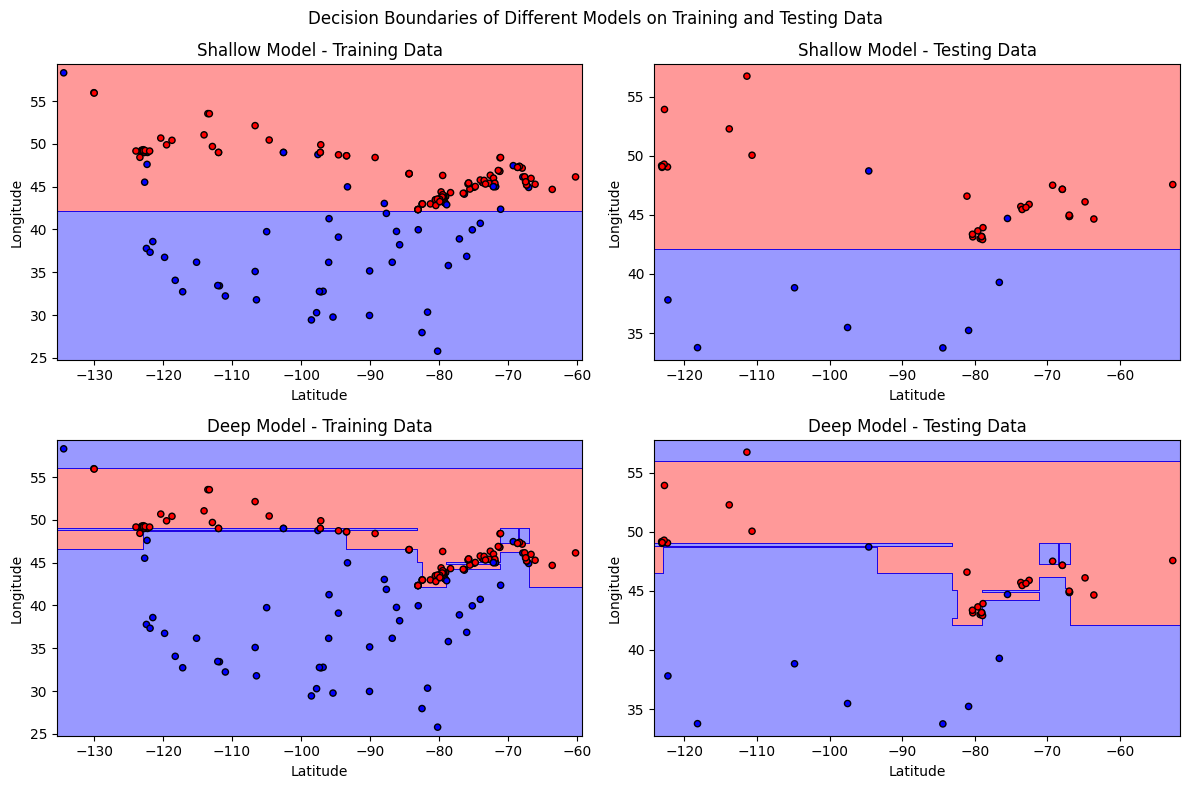

In [11]:
# Plot decision boundaries
def plot_decision_boundaries(ax, X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(('red', 'blue')))
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=ListedColormap(('red', 'blue')))
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')

# Prepare data
X_train_values = X_train.values
X_test_values = X_test.values
y_train_values = y_train.values
y_test_values = y_test.values

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Decision Boundaries of Different Models on Training and Testing Data")

# Plot decision boundaries for each model
plot_decision_boundaries(axes[0, 0], X_train_values, y_train_values, shallow_model, 'Shallow Model - Training Data')
plot_decision_boundaries(axes[0, 1], X_test_values, y_test_values, shallow_model, 'Shallow Model - Testing Data')
plot_decision_boundaries(axes[1, 0], X_train_values, y_train_values, deep_model, 'Deep Model - Training Data')
plot_decision_boundaries(axes[1, 1], X_test_values, y_test_values, deep_model, 'Deep Model - Testing Data')

plt.tight_layout()
plt.show()